In [1]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
palette = sns.color_palette('pastel')  

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, StandardScaler, QuantileTransformer

In [4]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, f1_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [5]:
# Machine Learning
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV , cross_val_score
from xgboost import XGBClassifier

In [6]:
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK

데이터 로딩 후 기본적 분석, 간단한 결측치 채우기

In [7]:
titanic_train = pd.read_csv('../input/titanic/train.csv') 
titanic_test = pd.read_csv('../input/titanic/test.csv')

In [8]:
titanic_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [9]:
titanic_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [10]:
titanic_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [11]:
print(titanic_train[titanic_train['Pclass'] == 1]['Embarked'].value_counts())

Embarked
S    127
C     85
Q      2
Name: count, dtype: int64


In [12]:
titanic_train['Embarked'] = titanic_train['Embarked'].fillna('S')

In [13]:
titanic_train[titanic_train['Age'].isna()].value_counts(['Sex', 'Pclass'])

Sex     Pclass
male    3         94
female  3         42
male    1         21
female  1          9
male    2          9
female  2          2
Name: count, dtype: int64

In [14]:
label = titanic_train['Survived']

데이터 분석을 위한 데이터 프레임 병합

In [15]:
titanic_data = pd.concat([titanic_train.iloc[:,1:], titanic_test.iloc[:,1:]], axis=0, sort=False)

In [16]:
titanic_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1309 entries, 0 to 417
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    float64
 1   Pclass    1309 non-null   int64  
 2   Name      1309 non-null   object 
 3   Sex       1309 non-null   object 
 4   Age       1046 non-null   float64
 5   SibSp     1309 non-null   int64  
 6   Parch     1309 non-null   int64  
 7   Ticket    1309 non-null   object 
 8   Fare      1308 non-null   float64
 9   Cabin     295 non-null    object 
 10  Embarked  1309 non-null   object 
dtypes: float64(3), int64(3), object(5)
memory usage: 122.7+ KB


In [17]:
titanic_data.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,0.383838,2.294882,29.881138,0.498854,0.385027,33.295479
std,0.486592,0.837836,14.413493,1.041658,0.865560,51.758668
min,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,39.000000,1.000000,0.000000,31.275000
max,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200


본격적 결측치 채우기 위한 시각화, 분석

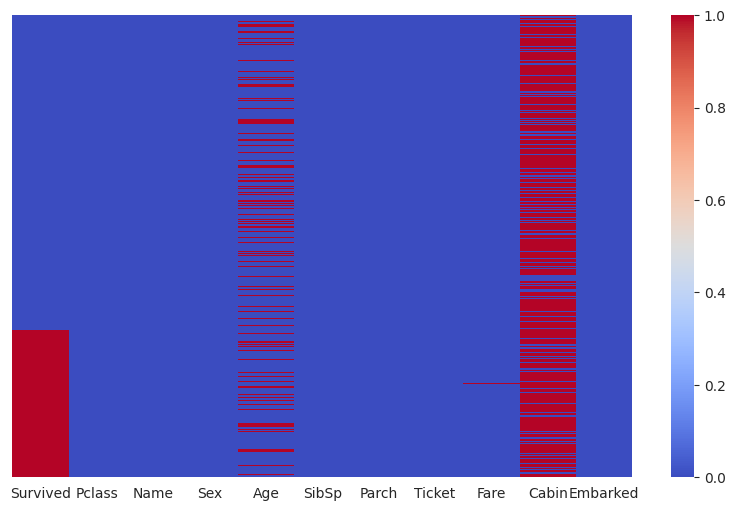

In [18]:
sns.set_style('whitegrid')
plt.figure(figsize=(10, 6))
sns.heatmap(titanic_data.isna(), yticklabels=False, cmap='coolwarm')
plt.show()

In [19]:
titanic_data[titanic_data['Cabin'].isna()].value_counts(['Pclass'])

Pclass
3         693
2         254
1          67
Name: count, dtype: int64

In [20]:
# Cabin 컬럼에 대한 결측치 처리(Pclass별로 가장 많은 Cabin으로 대체)
def cabin_modding(df):
    df['Cabin'] = df['Cabin'].str[0]
    df['Cabin'] = df.groupby('Pclass')['Cabin'].transform(lambda x: x.fillna(x.mode()[0]))
    return df

In [21]:
# 이름 컬럼에 있는 이명 호칭 추출
titanic_data['Title'] = titanic_data['Name'].str.split(',', expand = True)[1].str.split('.', expand = True)[0].str.strip(' ')

In [22]:
titanic_data['Title'].value_counts()

Title
Mr              757
Miss            260
Mrs             197
Master           61
Rev               8
Dr                8
Col               4
Mlle              2
Major             2
Ms                2
Lady              1
Sir               1
Mme               1
Don               1
Capt              1
the Countess      1
Jonkheer          1
Dona              1
Name: count, dtype: int64

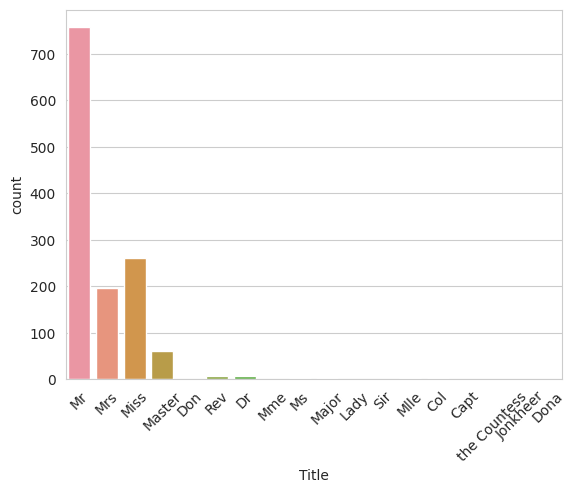

In [23]:
sns.countplot(x='Title', data=titanic_data)
plt.xticks(rotation=45)
plt.show()

In [24]:
def concat_train_test_data(df_train=None, df_test=None):
    df = pd.concat([df_train, df_test], axis=0, sort=False).reset_index(drop=True)
    
    # 정수로 고정해야 할 컬럼을 정수로 변환
    int_cols = ['PassengerId']
    for column in int_cols:
        df[column] = df[column].astype(int)
    return df

In [25]:
# 'Name' 컬럼에서 'Title' 컬럼 생성하기
# 의미있는 호칭(Mr, Mrs, Miss, Master)을 추출하는 과정입니다.

# 'Title' 생성하는 함수
def get_Title(name=None):
    general_titles = ('Mr', 'Mrs', 'Miss', 'Master')

    # top4 호칭으로 바꿔줄 소수 여성 호칭
    female_titles_to_Mrs = ('Mme', 'Ms', 'the Countess', 'Dona', 'Lady')
    female_titles_to_Miss = ('Mlle')

    # top4 호칭으로 바꿔줄 소수 남성 호칭
    male_titles_to_Mr = ('Major', 'Col', 'Capt', 'Don', 'Sir', 'Jonkheer', 'Rev')

    # 예 : "Braund, Mr. Owen Harris"에서 'Mr' 추출
    # '.'(마침표) 기준으로 이름을 자르고, ','(콤마) 제거
    title = name.split('.')[0].split(', ')[-1]

    # 호칭에 따라 변환해서 리턴
    if title in general_titles:
        return title
    elif title in female_titles_to_Mrs:
        return 'Mrs'
    elif title in female_titles_to_Miss:
        return 'Miss'
    elif title in male_titles_to_Mr:
        return 'Mr'
    else:
        return title


In [26]:

# 남녀 양쪽 전부 존재하는 호칭 처리 함수
def title_both_side(df=None):
    # 조건 설정
    title_on_both_side = ['Dr']
    cond_mr = (df['Sex'] == 'male') & (df['Title'].isin(title_on_both_side))
    cond_mrs = (df['Sex'] == 'female') & (df['Title'].isin(title_on_both_side))

    # 치환
    df.loc[cond_mr, 'Title'] = 'Mr'
    df.loc[cond_mrs, 'Title'] = 'Mrs'

    return df


In [27]:
# 'Title 생성
def make_Title(df=None):
    df['Title'] = df['Name'].map(get_Title)

    # 남녀 양쪽 전부 존재하는 호칭에 대한 처리
    df = title_both_side(df)

    return df

In [28]:
# 잘못된 데이터를 수정하는 함수 
def correct_wrong_passenger_info(df=None):
    df.loc[df['PassengerId'] == 631, 'Age'] = 48

    # Passengers with wrong number of siblings and parch
    df.loc[df['PassengerId'] == 69, ['SibSp', 'Parch']] = [0,0]
    df.loc[df['PassengerId'] == 1106, ['SibSp', 'Parch']] = [0,0]
    
    return df

In [29]:
titanic_data = make_Title(titanic_data)
titanic_data['Title'].value_counts()

Title
Mr        782
Miss      262
Mrs       204
Master     61
Name: count, dtype: int64

In [30]:
# Family 컬럼 생성
def mk_family(df=None):
    df['Family'] = df['SibSp'].astype(int) + df['Parch'].astype(int)
    return df


In [31]:
def make_Surname(df=None):
    df['Surname'] = df['Name'].map(lambda name: name.split(',')[0].strip())
    return df

In [32]:
def data_process_pipeline(df_train,df_test):
    df = concat_train_test_data(df_train, df_test)
    df['Embarked'] = df['Embarked'].fillna('S')
    df = cabin_modding(df)
    df = make_Surname(df)
    df = make_Title(df)
    df = mk_family(df)
    df = correct_wrong_passenger_info(df)
    return df

In [33]:
titanic_data = data_process_pipeline(titanic_train, titanic_test)

In [34]:
titanic_data.isna().sum()

PassengerId      0
Survived       418
Pclass           0
Name             0
Sex              0
Age            263
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin            0
Embarked         0
Surname          0
Title            0
Family           0
dtype: int64

Age에서 결측치 제거

In [35]:
titanic_data.groupby('Title')['Age'].agg({'mean', 'median'})

,median,mean
Title,,
Master,4.0,5.482642
Miss,22.0,21.795236
Mr,30.0,32.731405
Mrs,35.5,36.988636


In [36]:
titanic_data.groupby('Pclass')['Age'].agg({'mean', 'median', 'max'})

,max,median,mean
Pclass,,,
1,76.0,39.0,39.047254
2,70.0,29.0,29.506705
3,74.0,24.0,24.816367


In [37]:
# 'Age' 컬럼 결측치 채우기
def Age_Filler(df=None):
    df['Age'] = df.groupby('Title')['Age'].transform(lambda x: x.fillna(x.median()))
    df['Age'] = df['Age'].astype('int64')
    return df

In [38]:
# 'Fare' 컬럼 결측치 채우기
def Fare_Filler(df=None):
    df['Fare'] = df.groupby('Pclass')['Fare'].transform(lambda x: x.fillna(x.mean()))
    return df

In [39]:
def secondary_pipeline(df):
    df = Age_Filler(df)
    df = Fare_Filler(df)
    return df

In [40]:
titanic_data = secondary_pipeline(titanic_data)

In [41]:
titanic_data.isna().sum()

PassengerId      0
Survived       418
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin            0
Embarked         0
Surname          0
Title            0
Family           0
dtype: int64

In [42]:
# Pclsss 피쳐 변환 확인 
titanic_data.groupby('Pclass')['Fare'].agg({'mean', 'median'})

,median,mean
Pclass,,
1,60.0000,87.508992
2,15.0458,21.179196
3,8.0500,13.302889


In [43]:
# Age 변화를 확인
titanic_data.groupby('Title')['Age'].agg({'mean', 'median'}) 

,median,mean
Title,,
Master,4.0,5.180328
Miss,22.0,21.816794
Mr,30.0,32.095908
Mrs,35.0,36.715686


In [44]:
# 'Family_Survival' 컬럼 생성
def get_Family_Survival(df=None):
    def_survive_val = 0.5
    df['Family_Survival'] = def_survive_val
    survive_df = df[['Survived', 'Name', 'Surname'
                     , 'Fare', 'Ticket', 'PassengerId'
                     , 'SibSp', 'Parch', 'Age', 'Cabin']]

    for grp, grp_df in survive_df.groupby(['Surname', 'Fare']):
        if (len(grp_df) != 1):
            # 가족 그룹(같은 성씨, Fare 2명 이상)을 찾았다.
            for idx, row in grp_df.iterrows():
                max_sur = grp_df.drop(idx)['Survived'].max()
                min_sur = grp_df.drop(idx)['Survived'].min()
                passID = row['PassengerId']
                # 다른 가족의 생존 여부를 이 컬럼에 기록함
                if (max_sur == 1.0):
                    df.loc[df['PassengerId'] == passID, 'Family_Survival'] = 1
                elif (min_sur == 0.0):
                    df.loc[df['PassengerId'] == passID, 'Family_Survival'] = 0

    for _, grp_df in df.groupby('Ticket'):
        if (len(grp_df) != 1):
            # 같은 티켓번호를 가진 다른 사람을 찾았다.
            for idx, row in grp_df.iterrows():
                if (row['Family_Survival'] == 0) | (row['Family_Survival']== 0.5):
                    max_sur = grp_df.drop(idx)['Survived'].max()
                    min_sur = grp_df.drop(idx)['Survived'].min()
                    passID = row['PassengerId']
                    # 같은 티켓번호를 가진 다른 사람의 생존 여부를 이 컬럼에 기록함
                    if (max_sur == 1.0):
                        df.loc[df['PassengerId'] == passID, 'Family_Survival'] = 1
                    elif (min_sur == 0.0):
                        df.loc[df['PassengerId'] == passID, 'Family_Survival'] = 0

    return df

In [45]:
titanic_data=get_Family_Survival(titanic_data)

In [46]:
# Age를 범주화
def age_cutting(df=None):
    df['Age'] = pd.qcut(df['Age'], 4)
    return df


In [47]:
# Fare를 범주화
def fare_cutting(df=None):
    df['Fare'] = pd.qcut(df['Fare'], 4)
    return df

In [48]:
def cabin_labeling(df=None):
    encode = LabelEncoder()
    df['Cabin'] = encode.fit_transform(df['Cabin'])
    return df

In [49]:
def cutting_pipeline(df):
    df = age_cutting(df)
    df = fare_cutting(df)
    df = cabin_labeling(df)    
    return df

In [50]:
titanic_data = cutting_pipeline(titanic_data)

In [51]:
titanic_data.head()    

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Surname,Title,Family,Family_Survival
0,1,0.0,3,"Braund, Mr. Owen Harris",male,"(-0.001, 22.0]",1,0,A/5 21171,"(-0.001, 7.896]",5,S,Braund,Mr,1,0.5
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,"(35.0, 76.0]",1,0,PC 17599,"(31.275, 512.329]",2,C,Cumings,Mrs,1,0.5
2,3,1.0,3,"Heikkinen, Miss. Laina",female,"(22.0, 30.0]",0,0,STON/O2. 3101282,"(7.896, 14.454]",5,S,Heikkinen,Miss,0,0.5
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,"(30.0, 35.0]",1,0,113803,"(31.275, 512.329]",2,S,Futrelle,Mrs,1,0.0
4,5,0.0,3,"Allen, Mr. William Henry",male,"(30.0, 35.0]",0,0,373450,"(7.896, 14.454]",5,S,Allen,Mr,0,0.5


In [52]:
def drop_cols(df=None):
    drop_cols = ['Name', 'Ticket', 'PassengerId','Surname', 'SibSp', 'Parch']
    df = df.drop(drop_cols, axis=1)
    return df

In [53]:
# 성별 인코딩
def encode_label(df):
    label = LabelEncoder()
    cols = ['Sex', 'Embarked', 'Title', 'Fare', 'Age']
    df[cols] = df[cols].apply(label.fit_transform)
    return df

In [54]:
def last_pipeline(df):
    df = drop_cols(df)
    df = encode_label(df)
    return df

In [55]:
titanic_data = last_pipeline(titanic_data)

In [56]:
titanic_data.head()

,Survived,Pclass,Sex,Age,Fare,Cabin,Embarked,Title,Family,Family_Survival
0,0.0,3,1,0,0,5,2,2,1,0.5
1,1.0,1,0,3,3,2,0,3,1,0.5
2,1.0,3,0,1,1,5,2,1,0,0.5
3,1.0,1,0,2,3,2,2,3,1,0.0
4,0.0,3,1,2,1,5,2,2,0,0.5


In [57]:
# 학습데이터와 테스트데이터 분리
train_set = titanic_data.iloc[:titanic_train.shape[0],]
test_set = titanic_data.iloc[titanic_train.shape[0]:,]

# 학습데이터의 데이터와 답 분리
X_train = train_set.drop(['Survived'], axis=1)
y_train = train_set['Survived']

# 테스트데이터 생성
X_test = test_set.drop(['Survived'], axis=1)

In [58]:
def robust_scaling(X_train=None, X_test=None):
    
    scaler = RobustScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train, X_test


In [59]:
def quantile_trans(X_train=None, X_test=None):
    
    scaler = QuantileTransformer(n_quantiles=100, output_distribution='normal')
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train, X_test

In [60]:
def standard_scaling(X_train=None, X_test=None):
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train, X_test

In [61]:
X_train, X_test = quantile_trans(X_train, X_test)

In [62]:
X_tr, X_val, y_tr, y_val = train_test_split(
      X_train
    , y_train
    , test_size = 0.2
    , random_state = 72
)


In [63]:
# 1 step : search space 설정, XGBosst 하이퍼파라미터들의 범위 지정
xgb_search_space = {
      'max_depth' : hp.quniform('max_depth', 4, 20, 1) # return float
    , 'min_child_weight' : hp.quniform('min_child_weight', 1, 12, 0.5)
    , 'learning_rate' : hp.uniform('learning_rate', 0.01, 0.2)
    , 'colsample_bytree' : hp.uniform('colsample_bytree', 0.5, 1)
}


In [64]:
# 2 step : objective function => return acccuracy, auc
def objective_func(search_space):
    xgb_clf = XGBClassifier(
          n_estimators=500
        , objective='binary:logistic'
        , max_depth=int(search_space['max_depth'])
        , min_child_weight=int(search_space['min_child_weight'])
        , learning_rate=search_space['learning_rate']
        , colsample_bytree=search_space['colsample_bytree']
        , eval_metric='logloss'
    )
    accuracy = cross_val_score(
          xgb_clf
        , X_train
        , y_train
        , scoring='accuracy'
        , cv=5
    )
    return {'loss':-1*np.mean(accuracy), 'status':STATUS_OK}

In [65]:
trial_val = Trials() # 결과 저장하는 객체
best = fmin(
      fn=objective_func
    , space=xgb_search_space
    , algo=tpe.suggest
    , max_evals=50
    , trials=trial_val # 중간 결과 저장
    , rstate=np.random.default_rng(seed=72))

100%|██████████| 50/50 [00:55<00:00,  1.11s/trial, best loss: -0.8563178708179022]


In [66]:
print(f'best : {best}')
print(f'best score : {-1*trial_val.best_trial["result"]["loss"]:.4f}')

best : {'colsample_bytree': 0.788890500583923, 'learning_rate': 0.06368951791204792, 'max_depth': 8.0, 'min_child_weight': 9.5}
best score : 0.8563


In [67]:
xgb_clf = XGBClassifier(
      n_estimatior=300
    , objective='binary:logistic'
    , learning_rate=np.round(best['learning_rate'],5)
    , max_depth=int(best['max_depth'])
    , min_child_weight=int(best['min_child_weight'])
    , colsample_bytree=np.round(best['colsample_bytree'],5)
    , early_stopping_rounds=100
    , eval_metric='logloss'
)

In [68]:
evals = [(X_tr,y_tr),(X_val,y_val)]
# 학습 진행
xgb_clf.fit(
      X_tr
    , y_tr
    ,eval_set=evals
    , verbose=True
)

[0]	validation_0-logloss:0.63827	validation_1-logloss:0.64514
[1]	validation_0-logloss:0.61433	validation_1-logloss:0.62105
[2]	validation_0-logloss:0.59337	validation_1-logloss:0.60020
[3]	validation_0-logloss:0.57489	validation_1-logloss:0.58202
[4]	validation_0-logloss:0.55849	validation_1-logloss:0.56610
[5]	validation_0-logloss:0.54413	validation_1-logloss:0.55046
[6]	validation_0-logloss:0.53077	validation_1-logloss:0.53680
[7]	validation_0-logloss:0.51869	validation_1-logloss:0.52586
[8]	validation_0-logloss:0.50816	validation_1-logloss:0.51304
[9]	validation_0-logloss:0.49839	validation_1-logloss:0.50268
[10]	validation_0-logloss:0.48919	validation_1-logloss:0.49361
[11]	validation_0-logloss:0.48074	validation_1-logloss:0.48660
[12]	validation_0-logloss:0.47293	validation_1-logloss:0.47883
[13]	validation_0-logloss:0.46587	validation_1-logloss:0.47323
[14]	validation_0-logloss:0.45955	validation_1-logloss:0.46721
[15]	validation_0-logloss:0.45487	validation_1-logloss:0.46184
[1

/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [16:41:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "n_estimatior" } are not used.

  warnings.warn(smsg, UserWarning)


[52]	validation_0-logloss:0.36792	validation_1-logloss:0.39468
[53]	validation_0-logloss:0.36717	validation_1-logloss:0.39424
[54]	validation_0-logloss:0.36625	validation_1-logloss:0.39413
[55]	validation_0-logloss:0.36564	validation_1-logloss:0.39390
[56]	validation_0-logloss:0.36504	validation_1-logloss:0.39425
[57]	validation_0-logloss:0.36436	validation_1-logloss:0.39385
[58]	validation_0-logloss:0.36370	validation_1-logloss:0.39359
[59]	validation_0-logloss:0.36321	validation_1-logloss:0.39361
[60]	validation_0-logloss:0.36260	validation_1-logloss:0.39323
[61]	validation_0-logloss:0.36168	validation_1-logloss:0.39261
[62]	validation_0-logloss:0.36121	validation_1-logloss:0.39298
[63]	validation_0-logloss:0.36062	validation_1-logloss:0.39283
[64]	validation_0-logloss:0.36013	validation_1-logloss:0.39291
[65]	validation_0-logloss:0.35912	validation_1-logloss:0.39235
[66]	validation_0-logloss:0.35851	validation_1-logloss:0.39214
[67]	validation_0-logloss:0.35796	validation_1-logloss:

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.78889, device=None, early_stopping_rounds=100,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.06369, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=9, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimatior=300,
              n_estimators=None, n_jobs=None, num_parallel_tree=None, ...)

In [69]:
prec = xgb_clf.predict(X_test)

In [70]:
from xgboost import plot_importance
def plot_feature_importance(xgb_clf=None):
    fig, ax = plt.subplots(figsize=(10,8))
    plot_importance(xgb_clf, ax=ax)
    plt.show()
    return

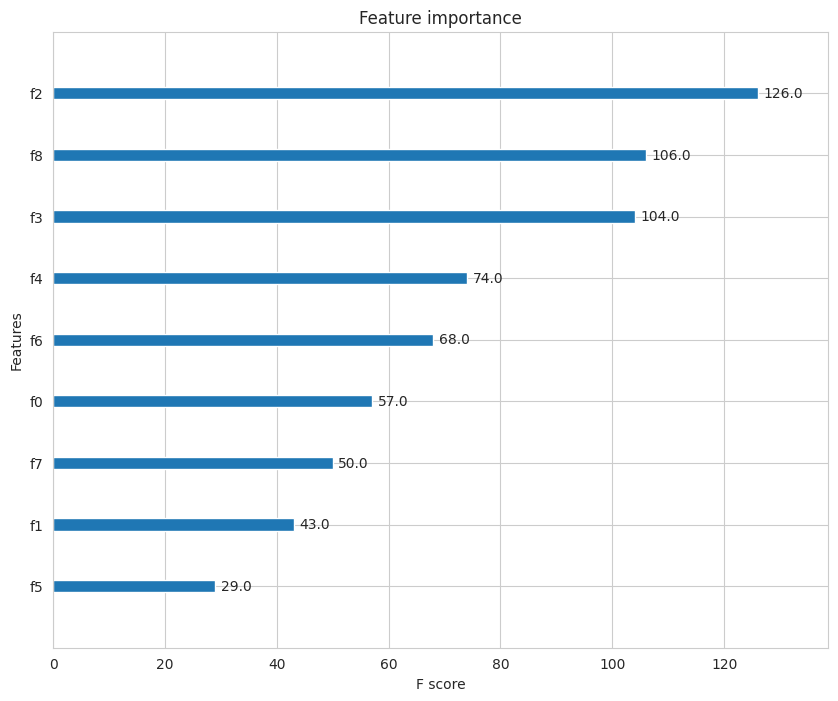

In [71]:
plot_feature_importance(xgb_clf)

In [72]:
def make_submission_file(df_test=None, pred=None):
    # 제출파일 => PassengerId, pred
    submission = pd.DataFrame({
        'PassengerId' : df_test['PassengerId'],
        'Survived' : pred
    })

    submission['Survived'] = submission['Survived'].astype(int)

    # 제출파일 저장
    submission.to_csv('submission_xgb.csv', index=False)
    print('저장이 완료 되었습니다.!')
    return


In [73]:
make_submission_file(titanic_test, prec)

저장이 완료 되었습니다.!
